# CRA prediction with Regression

Reference [link](https://www.kaggle.com/apapiu/regularized-linear-models).

#### Importing packages

This packages will be used to analysis data and train the models.

In [1]:
#enconding=utf8
import copy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

#### Reading data

This command shows a sample from data read. We can observe that predict column is "CRA", and the other are features to train our model. The "Matricula" column shows an irrelevant feature that indicates the student identification. So, we do not consider this in training phase.

In [2]:
data = pd.read_csv("treino.csv")
data.columns = ['matricula', 'vetorial','lpt','p1','ic','lp1','calculo2','discreta','p2','grafos','fis_classica','lp2','cra','calculo1']
data.head()

,matricula,vetorial,lpt,p1,ic,lp1,calculo2,discreta,p2,grafos,fis_classica,lp2,cra,calculo1
0,0cc3d63edf0b986cb87e345972857e15,8.6,10.0,9.0,9.1,8.6,8.4,8.3,8.8,8.2,7.9,9.4,8.477647,8.7
1,0d78246db769dc958ce19fc414050b2a,5.6,7.0,7.7,7.0,8.1,6.2,7.3,8.2,5.4,7.7,8.9,6.851724,7.0
2,0f5bb983df06b90337dc2c6301fef3f6,10.0,9.8,7.9,9.6,8.3,8.7,8.8,9.5,9.2,8.6,9.7,9.090588,8.6
3,1307a4421a67a497cea198e8ccfb97ee,6.1,8.3,6.8,8.2,7.1,8.0,6.3,8.9,7.0,8.5,9.0,7.283516,7.8
4,1432d50cf8519694ab992c414d90a130,8.8,9.3,5.0,8.5,5.1,5.0,5.8,7.1,5.4,8.7,8.2,7.205747,5.2


### Distribuition analysis

#### Plot graphics

To see the distribution of predict feature (CRA), we plot the graph of distribution. We can plot to all features, but to resume data, we'll visualize only predict feature.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc624352890>]], dtype=object)

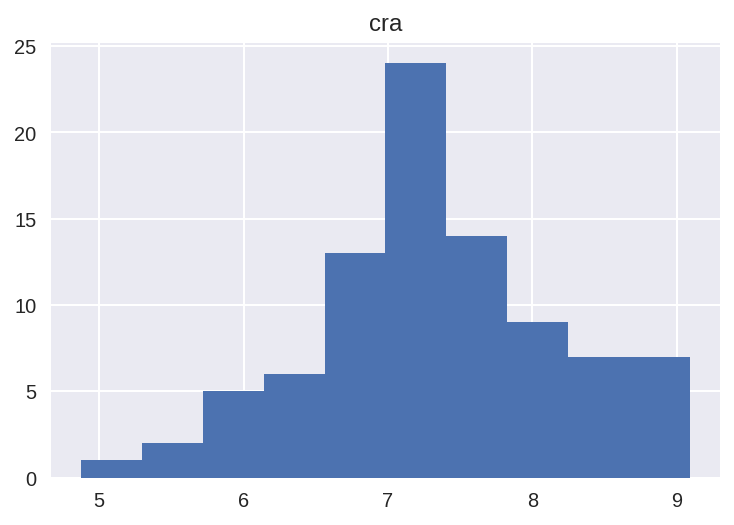

In [3]:
'''
pd.DataFrame(data.vetorial).hist()
pd.DataFrame(data.lpt).hist()
pd.DataFrame(data.p1).hist()
pd.DataFrame(data.ic).hist()
pd.DataFrame(data.lp1).hist()
pd.DataFrame(data.calculo1).hist()
pd.DataFrame(data.calculo2).hist()
pd.DataFrame(data.discreta).hist()
pd.DataFrame(data.p2).hist()
pd.DataFrame(data.grafos).hist()
pd.DataFrame(data.fis_classica).hist()
pd.DataFrame(data.lp2).hist()
'''
pd.DataFrame(data.cra).hist()

### Check skew in data

#### Skewness analysis

Let's check the skewness of data if a feature has skewness bigger than 0.75 or less than -0.75, it indicates that the feature distribution has skewness. In this case, only "LP2" feature has a strong skewness (-1.9).

In [4]:
def check_skewness(data, thresh=0.75):
    numeric_feats = data.dtypes[data.dtypes != "object"].index
    skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    features_index = skewed_feats[(skewed_feats < -thresh) | (skewed_feats > thresh)]
    return features_index

In [5]:
features_index = check_skewness(data)

print(features_index)

lp2   -1.905429
dtype: float64


It was observed that LP2 discipline has skew, so to treat this bias, it was used exponent function.

In the graphic below, we can observe that multiplies points in the board are very distant from red line. Data without skewness will appear close to red line.

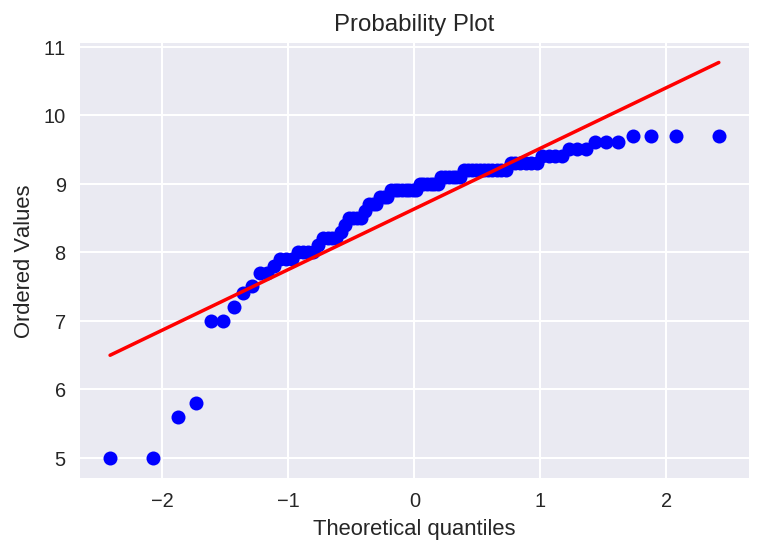

In [6]:
from scipy import stats
import matplotlib.pyplot as plt

index = features_index.index[0]
lp2 = data[index]
res = stats.probplot(lp2, plot=plt)

#### Treating "LP2" skew:

In [8]:
#exp transform skewed numeric features:
data[features_index.index] = np.exp(data[features_index.index]) # ".index" get the column name

features_index = check_skewness(data)

print(features_index)

Series([], dtype: float64)


After applying exponential function in this feature, it was removed the skewness of -1.9.

After applying exponential function in this feature, the data closer to the red line.

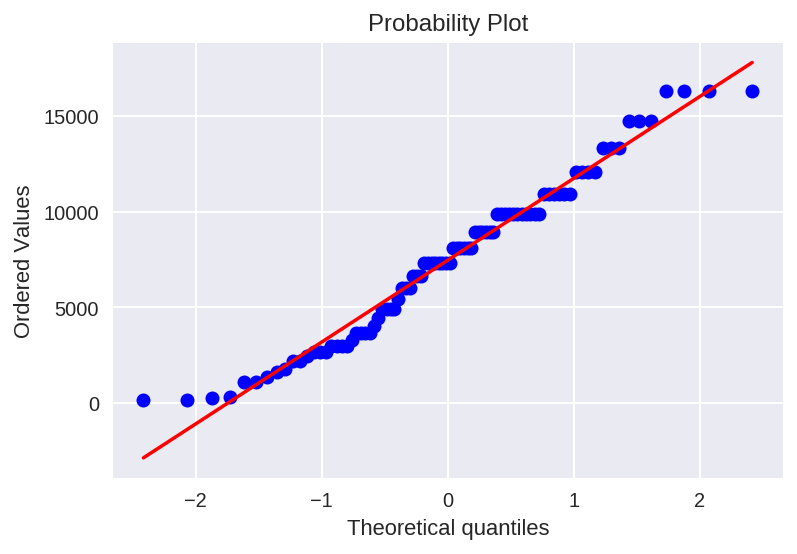

In [9]:
lp2 = data[index]
res = stats.probplot(lp2, plot=plt)

### Is necessary fill missing values?

In [10]:
data.isnull().apply(pd.value_counts)

,matricula,vetorial,lpt,p1,ic,lp1,calculo2,discreta,p2,grafos,fis_classica,lp2,cra,calculo1
False,88,88,88,88,88,88,88,88,88,88,88,88,88,88


No. How can be observed, all features have 88 values, or none line is the missing value because all matrix has 88 lines.

  #### Preprocessing data

In [11]:
H = data.drop(['matricula', 'cra'], 1)
y = data['cra']

## RIDGE Regression

In [12]:
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model, X_train, y, cv_num):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = cv_num))
    return(rmse)

#### Training Ridge Regression with different lambda

In [14]:
alphas = [0.0, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 40, 50, 60, 70, 80]
cv_num = 5
cv_ridge = [rmse_cv(Ridge(alpha = alpha), H, y, cv_num)
            for alpha in alphas]

#### Ploting RMSE in Ridge Regression

##### Ploting graphic

In [15]:
def plot_graphic(X, index, title, xlabel, ylabel, label):
    cv_ridge = pd.Series(X, index = index)
    cv_ridge.plot(title = title, label = label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

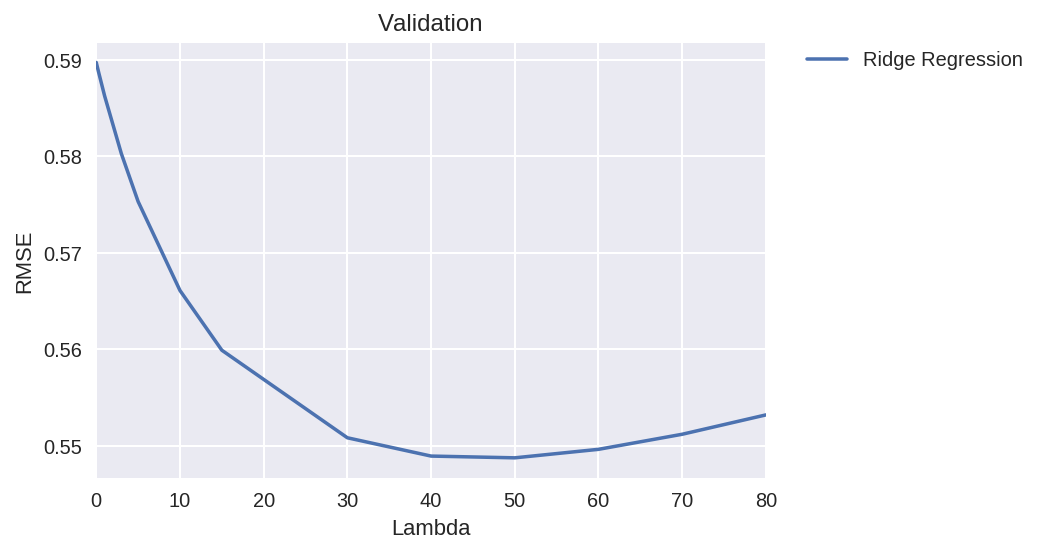

In [16]:
cv_ridge_mean = np.mean(cv_ridge, axis=1)
title = "Validation"
xlabel = "Lambda"
ylabel = "RMSE"
label = "Ridge Regression"
plot_graphic(cv_ridge_mean, alphas, title, xlabel, ylabel, label)

In [18]:
small_pos_r = np.argmin(cv_ridge_mean) # small position
small_lambda_r = alphas[small_pos_r]
small_rmse_r = cv_ridge_mean[small_pos_r]

print("RMSE with lambda = {0}: {1}".format(small_lambda_r, small_rmse_r))
print("RMSE without regularization: {0}".format(cv_ridge_mean[0]))

RMSE with lambda = 50: 0.548758261756
RMSE without regularization: 0.589695464042


In this graphic, we can observe the Root Mean Square Error for different lambdas. The smallest error is desirable, in this case, when lambda = 50. And, without regularization (lambda=0), the results were worst in interval [0:80]. 

Besides that, the RMSE without regularization is bigger than Lasso using lambda = 50.

#### Plotting error in cross with smallest RMSE

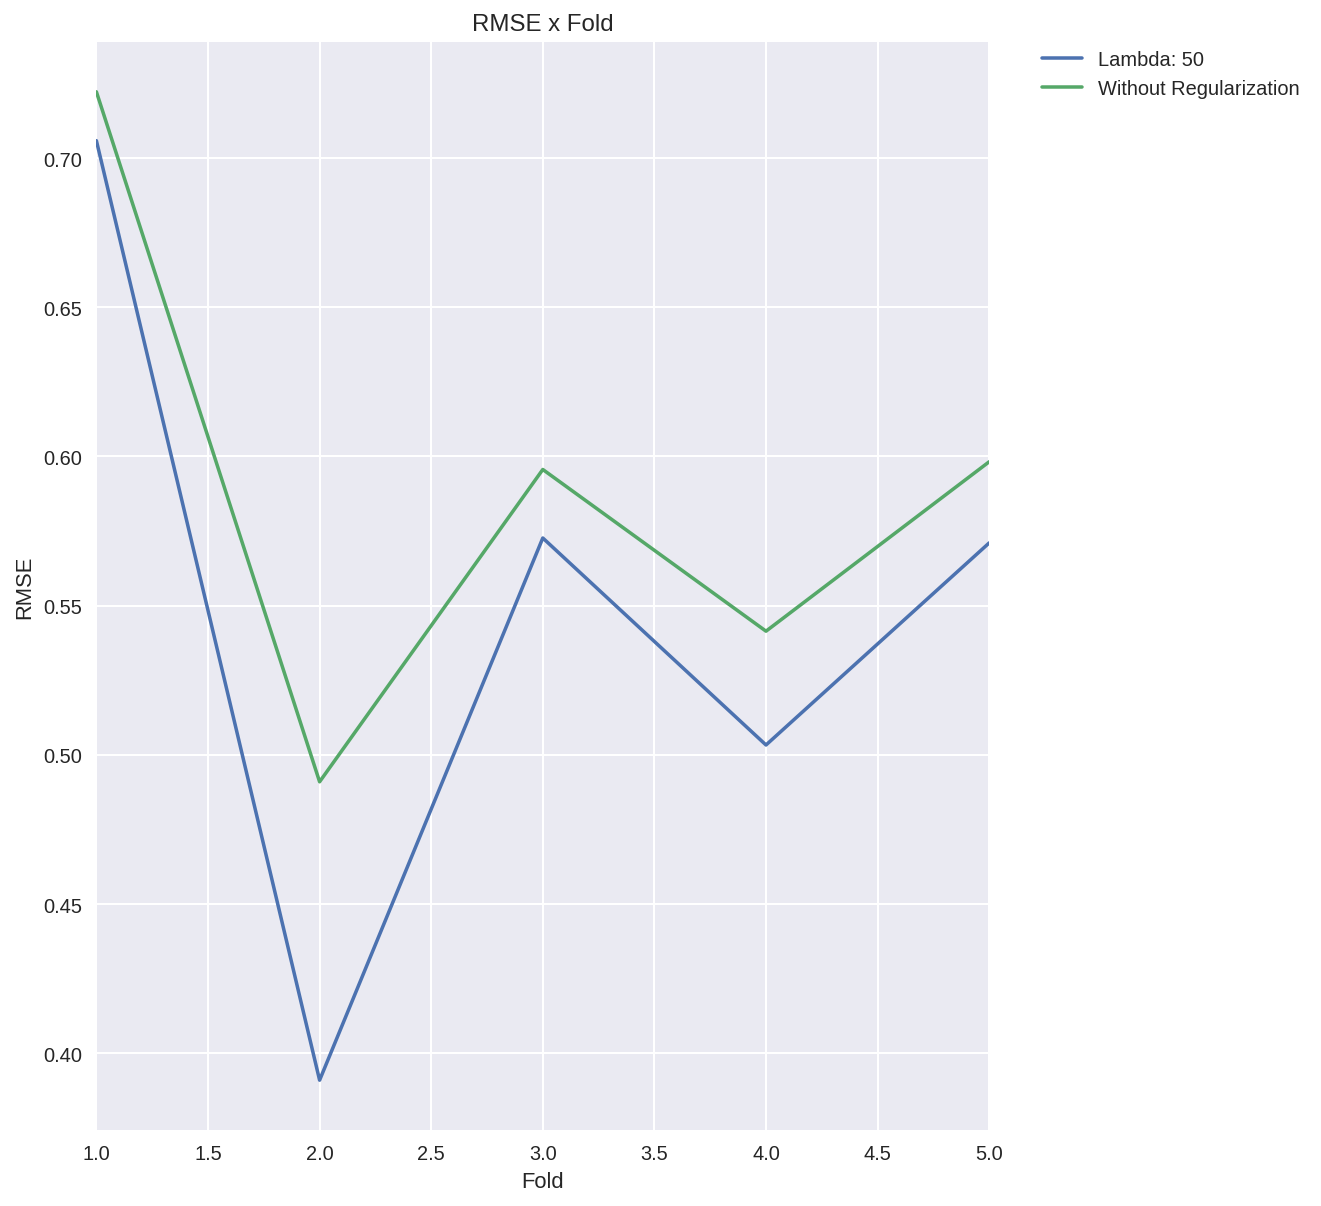

In [146]:
seq = np.arange(1, cv_num+1) # 1, ..., cv_num
small_rmse_ridge = cv_ridge[small_pos_r]
plot_graphic(small_rmse_ridge, seq, "RMSE x Fold", "Fold", "RMSE", "Lambda: {0}".format(small_lambda_r))
plot_graphic(cv_ridge[0], seq, "RMSE x Fold", "Fold", "RMSE", "Without Regularization") #Without Regularization

In this graphic, we can observe the RMSE to each cross using lambda=50 (smallest RMSE) and without regularization (bigger RMSE in the interval [0-80]).

The variation in each cross (until 0.3) indicates that some cross is very different each other.

#### Training a model with all data

In [22]:
ols = Ridge(alpha=0.0)
ridge_adjusted = Ridge(alpha=small_lambda_r)

#Training data
ols.fit(H, y)
ridge_adjusted.fit(H, y)

Ridge(alpha=50, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

## LASSO Regression

Training data with Lasso regression with and without regularization.

/home/italo/.local/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/home/italo/.local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/home/italo/.local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


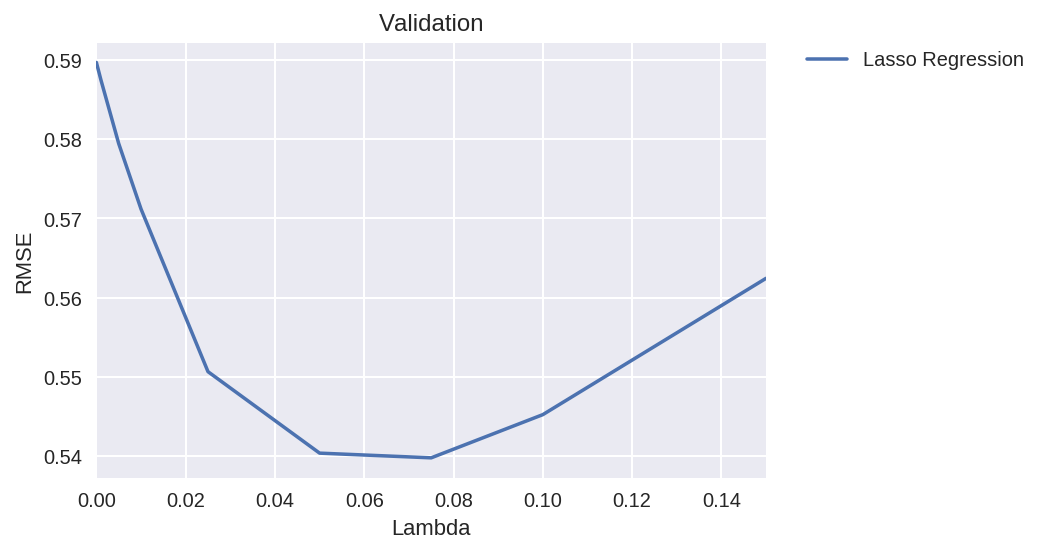

In [23]:
from sklearn import linear_model
alphas = [0.0, 0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15]
cv_lasso = [rmse_cv(linear_model.Lasso(alpha = alpha), H, y, cv_num)
            for alpha in alphas]

cv_lasso_mean = np.mean(cv_lasso, axis=1)

label = "Lasso Regression"
plot_graphic(cv_lasso_mean, alphas, title, xlabel, ylabel, label)

The smallest lambda was 0.075 with RMSE = 0.54. And the RMSE is bigger when regularization is not used (lambda=0).

In [24]:
small_pos = np.argmin(cv_lasso_mean) # small position
small_lambda = alphas[small_pos]
small_rmse = cv_lasso_mean[small_pos]

print("RMSE with lambda = {0}: {1}".format(small_lambda, small_rmse))
print("RMSE without regularization: {0}".format(cv_lasso_mean[0]))

RMSE with lambda = 0.075: 0.539785080692
RMSE without regularization: 0.589695464042


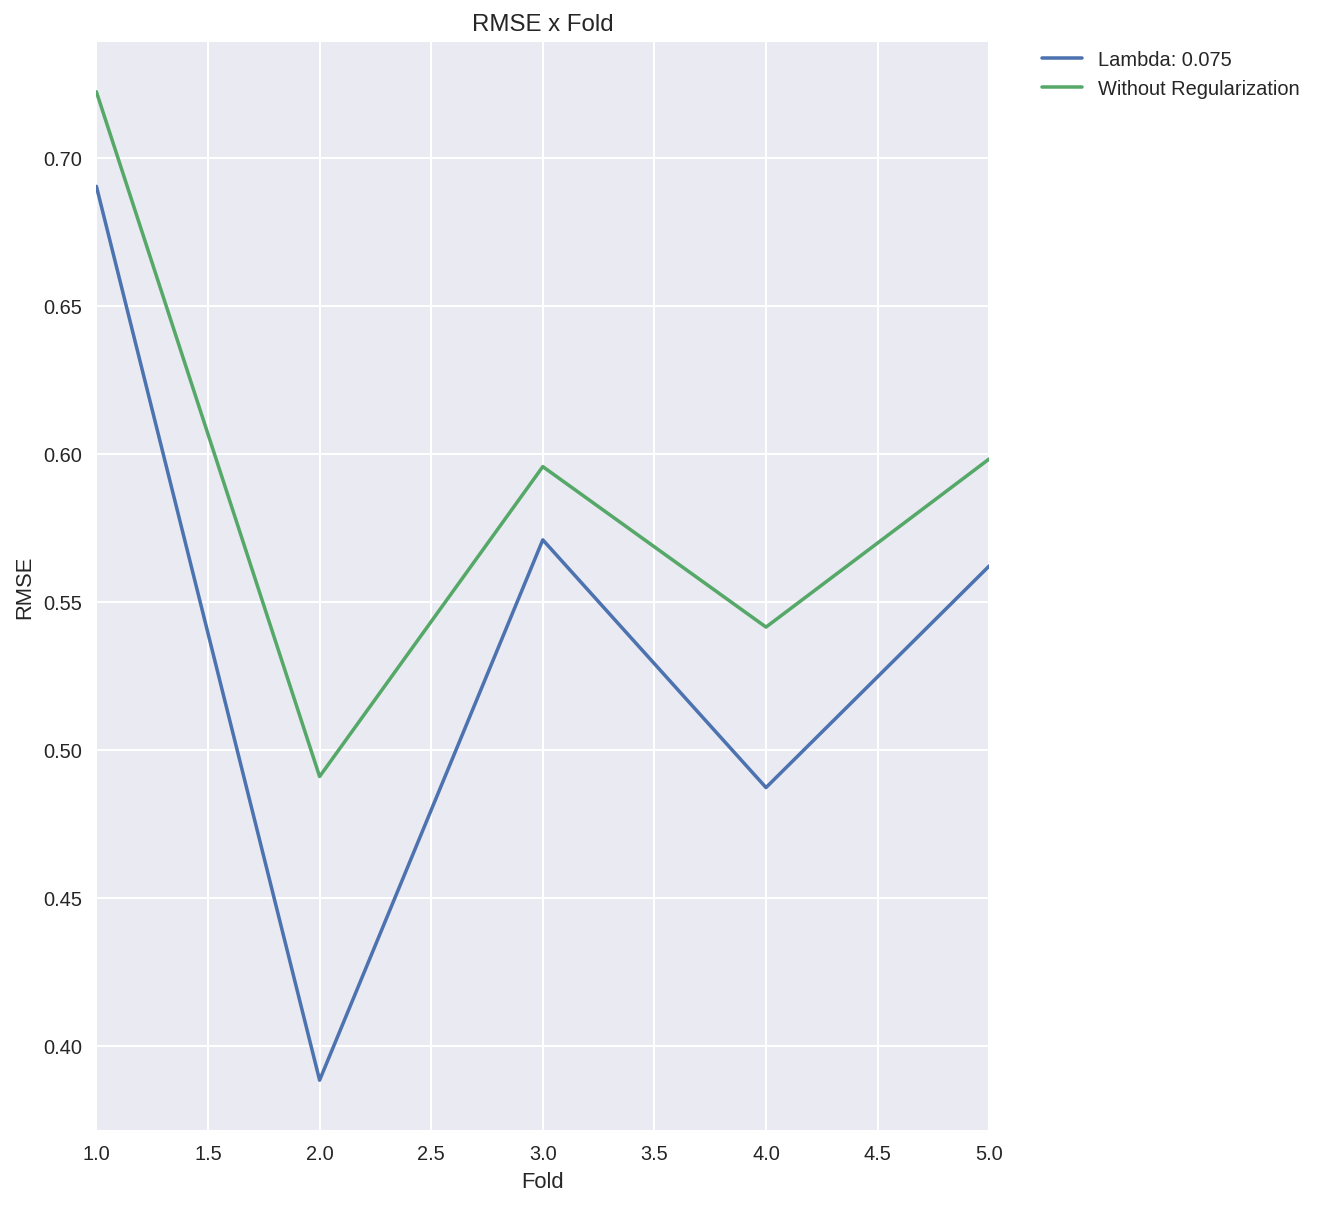

In [147]:
small_rmse_lasso = cv_lasso[small_pos]
plot_graphic(small_rmse_lasso, seq, "RMSE x Fold", "Fold", "RMSE", "Lambda: {0}".format(small_lambda))
plot_graphic(cv_lasso[0], seq, "RMSE x Fold", "Fold", "RMSE", "Without Regularization") #Without Regularization

In this graphic, we can observe the RMSE to each cross using lambda=0.075 (smallest RMSE) and without regularization (bigger RMSE in the interval [0-0.15]).

The variation in each cross (until 0.3) indicates that some cross is very different each other.

Besides that, using Lasso with lambda = 0.075 get RMSE = 0.54, while Ridge using lambda = 50 provides RMSE = 0.55. A small difference between the models.

#### Training a model with all data  and comparing the coefficients

In [26]:
lasso_adjusted = linear_model.Lasso(alpha=small_lambda)
lasso_adjusted.fit(H, y)

from numpy import linalg as LA
print("Norma OLS: {0}".format(LA.norm(ols.coef_)))
print("Norma Ridge (lambda={0}): {1}".format(small_lambda_r, LA.norm(ridge_adjusted.coef_)))
print("Norma Lasso (lambda={0}): {1}".format(small_lambda, LA.norm(lasso_adjusted.coef_)))

Norma OLS: 0.367397692096
Norma Ridge (lambda=50): 0.268388764367
Norma Lasso (lambda=0.075): 0.292663862559


We can observe that with regularization, we obtain the smallest norma of coefficients.

## KNN

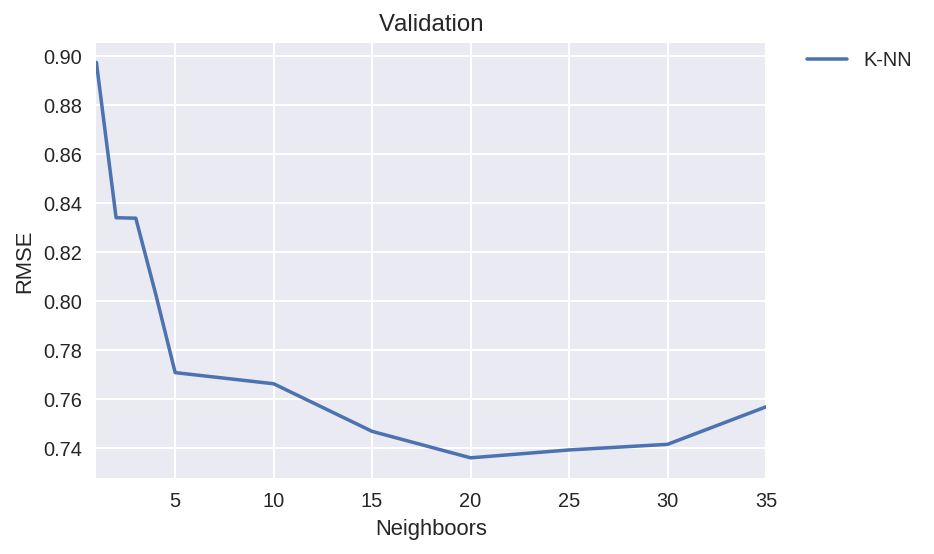

In [29]:
from sklearn.neighbors import KNeighborsRegressor

neighboor=[1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35]
cv_num = 5
cv_knn = [rmse_cv(KNeighborsRegressor(n_neighbors = n), H, y, cv_num) for n in neighboor]

cv_knn_mean = np.mean(cv_knn, axis=1)

xlabel = "Neighboors"
label = "K-NN"
plot_graphic(cv_knn_mean, neighboor, title, xlabel, ylabel, label)

In this graphic, it was observed that the smallest RMSE (0.736) is when using neighbor = 20.

#### Neighbor comparison

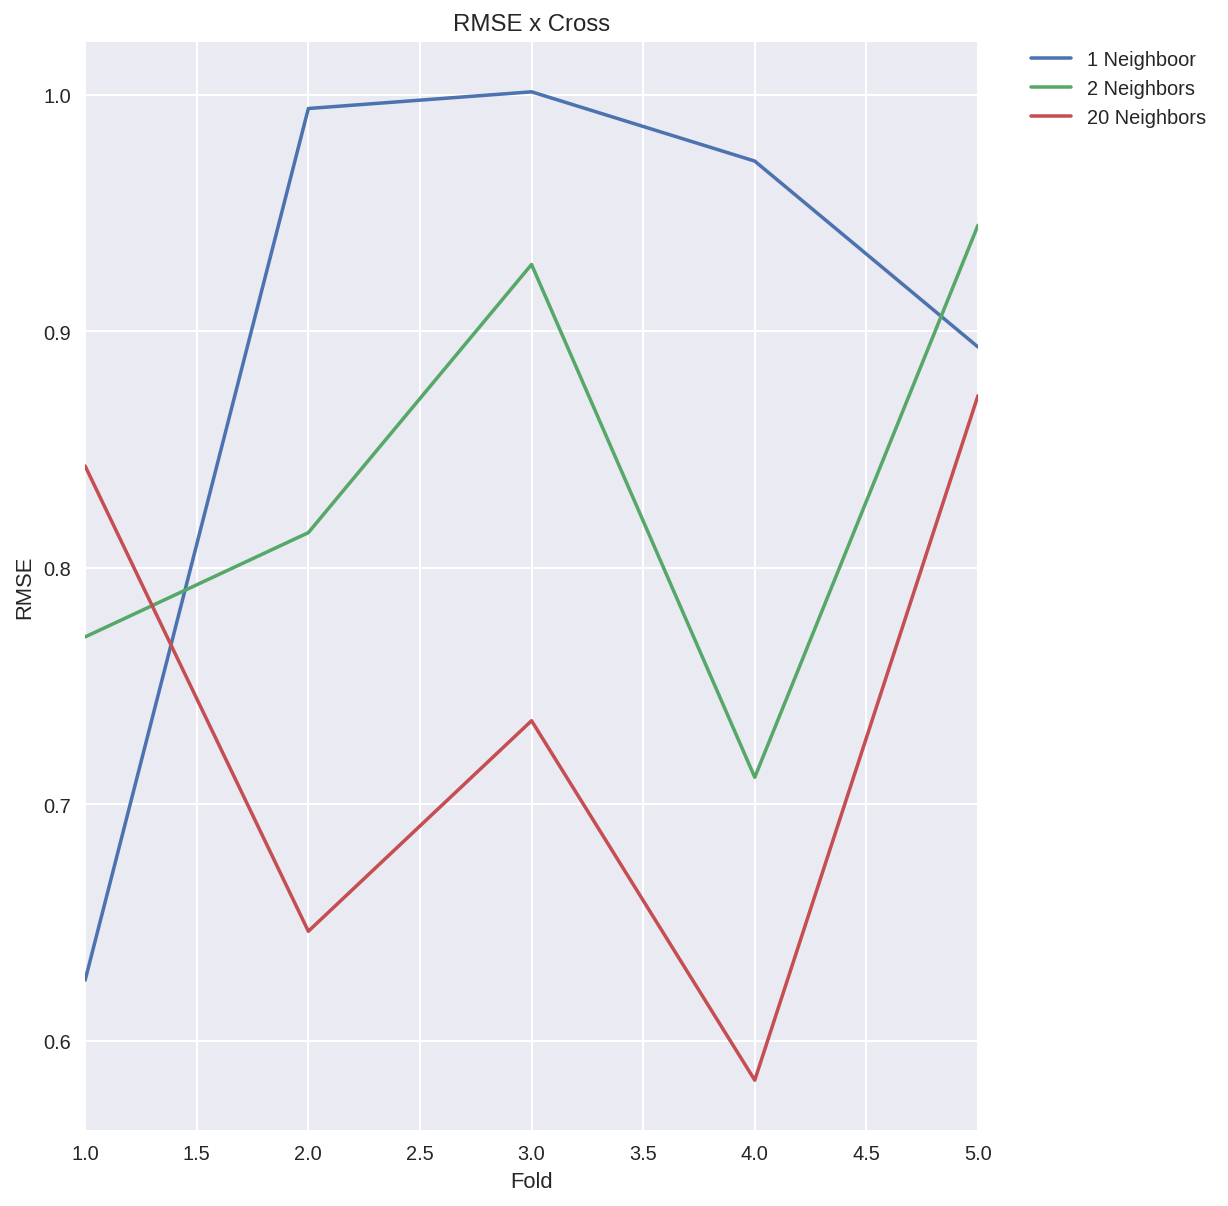

In [145]:
small_pos_knn = np.argmin(cv_knn_mean) 
small_neighbor_knn = neighboor[small_pos_knn]
small_rmse_knn = cv_knn_mean[small_pos_knn]

small_rmse_knn = cv_knn[small_pos_knn]

plot_graphic(cv_knn[0], seq, "RMSE x Cross", "Fold", "RMSE", "1 Neighboor")
plot_graphic(cv_knn[1], seq, "RMSE x Cross", "Fold", "RMSE", "2 Neighbors")
plot_graphic(small_rmse_knn, seq, "RMSE x Cross", "Fold", "RMSE", "{0} Neighbors".format(small_neighbor_knn))

In this graphic, it was observed that the RMSE in each cross for 1, 2 and 20 neighbors.

#### Training K-NN with the best number of neighbors

In [130]:
neighbor = KNeighborsRegressor(n_neighbors=small_neighbor_knn)
neighbor.fit(H, y) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=20, p=2,
          weights='uniform')

## Residual versus Prediction

### Ridge

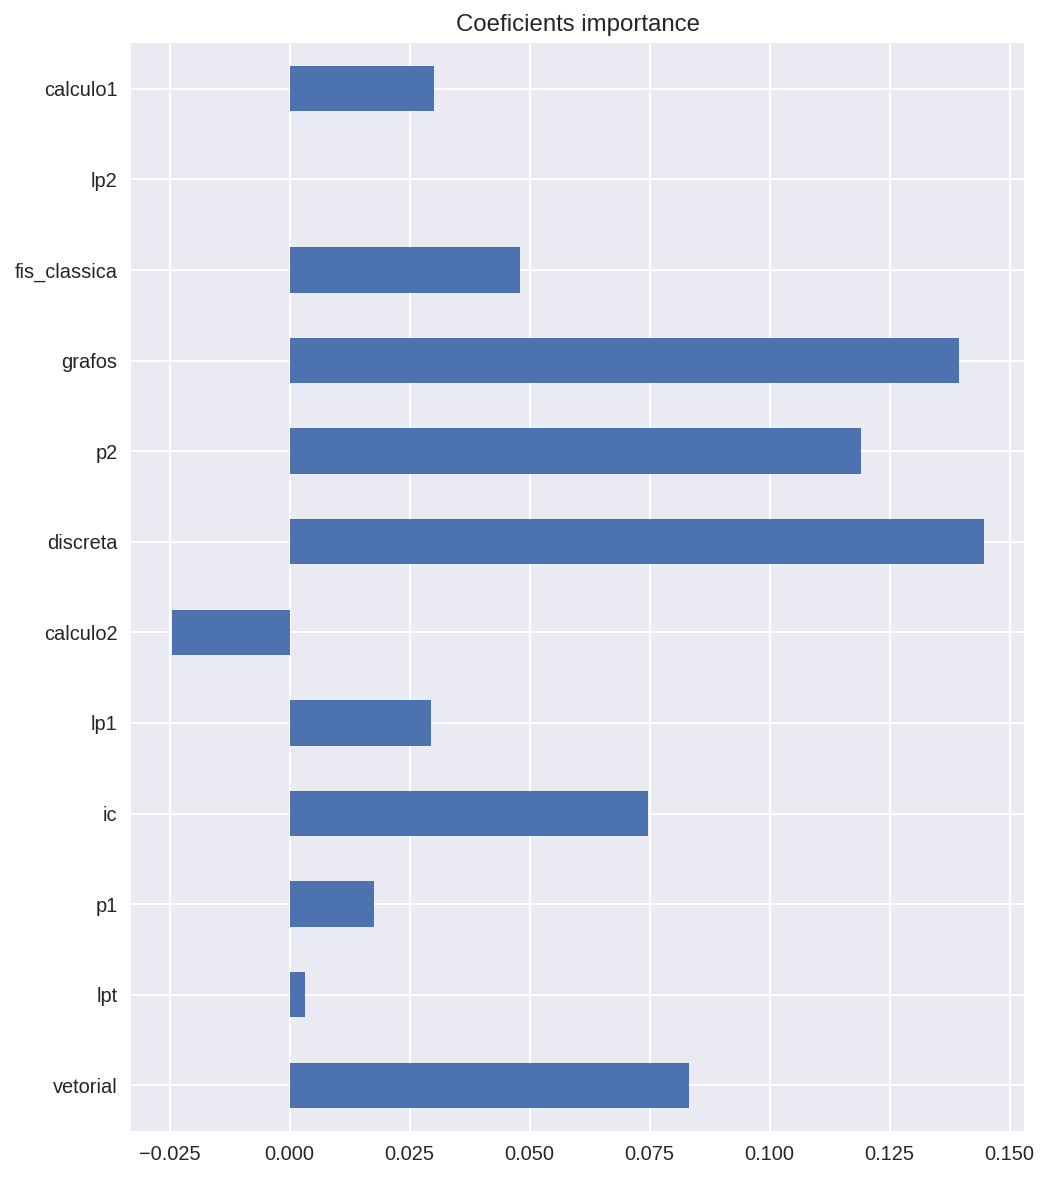

In [41]:
def plot_coeficients(values, names):
    coef = pd.Series(values, index = names)
    matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
    coef.plot(kind = "barh")
    plt.title("Coeficients importance")
    
plot_coeficients(ridge_adjusted.coef_, H.columns)

In this graphic, shows that features: Grafos, P2, and Discreta are the most important features to predict CRA. While LP1, LP2, P1, and LPT are the less important.

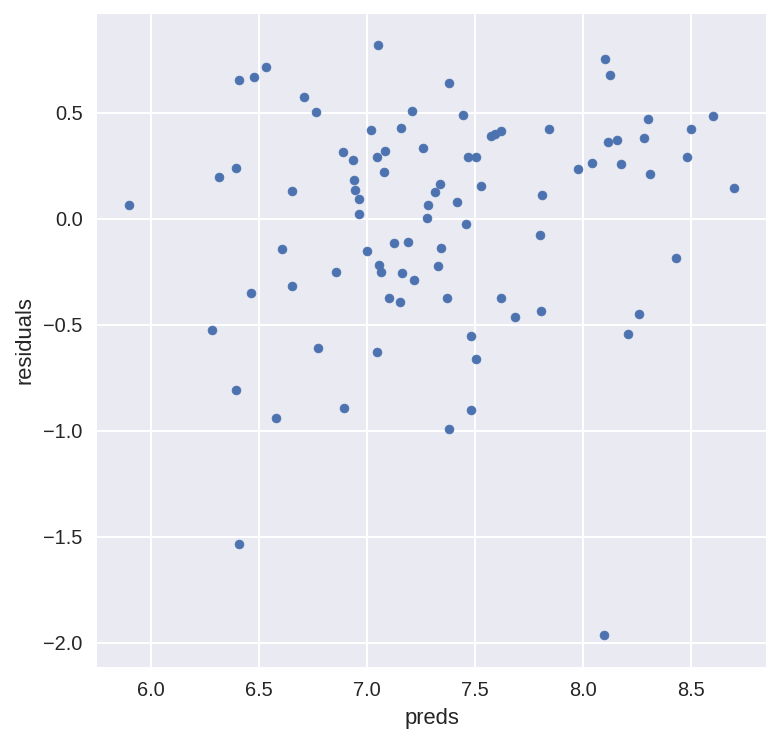

In [34]:
def plot_residual(model, X, y):
    matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
    preds = pd.DataFrame({"preds":model.predict(X), "true":y})
    preds["residuals"] = preds["true"] - preds["preds"]
    preds.plot(x = "preds", y = "residuals",kind = "scatter")

plot_residual(ridge_adjusted, H, y)

This graphic shows that the trained model has no bias with data.

### Lasso

Lasso picked 6 variables and eliminated the other 6 variables


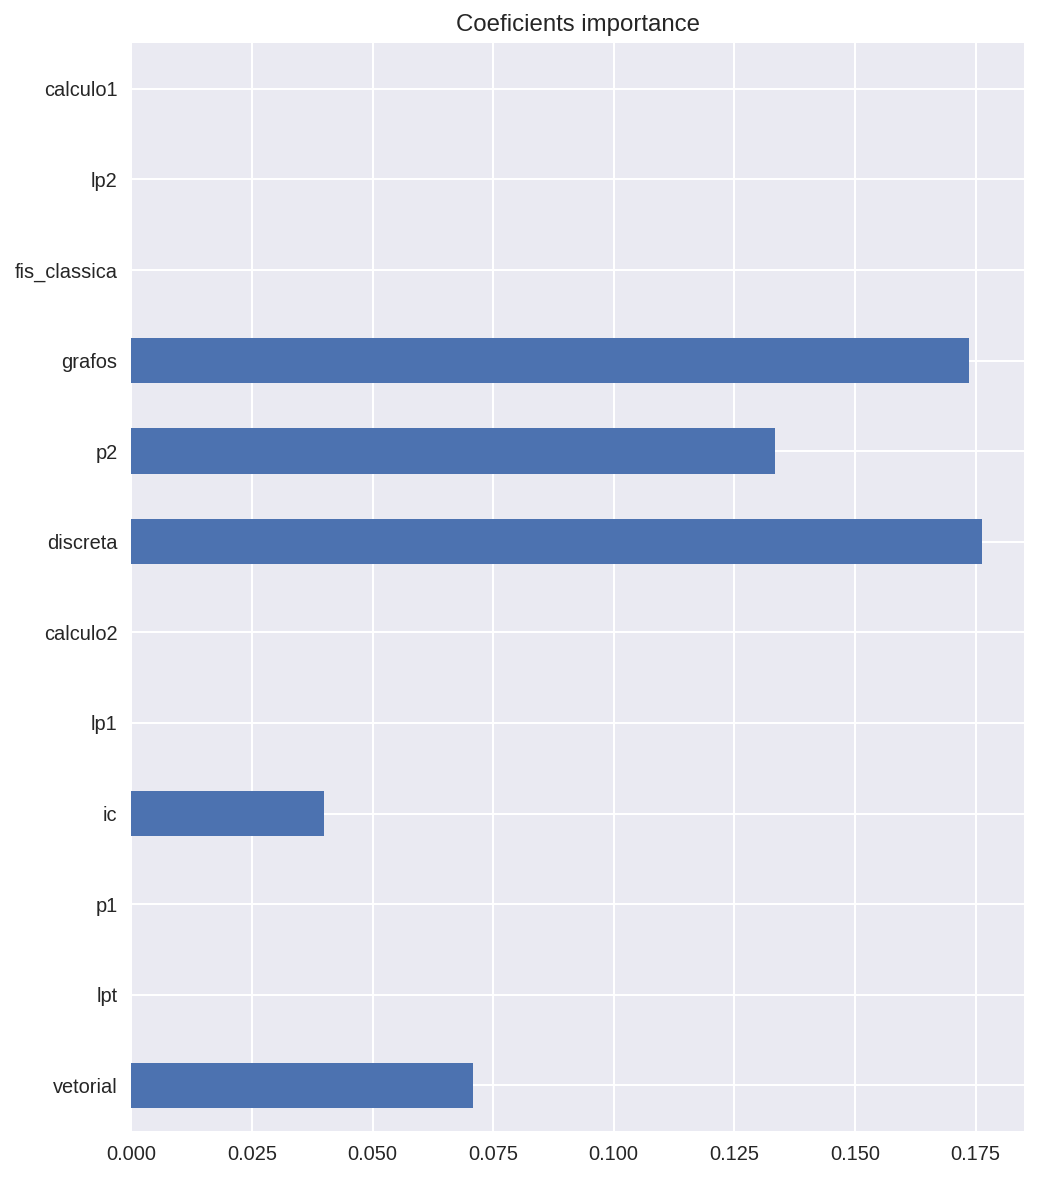

In [42]:
plot_coeficients(lasso_adjusted.coef_, H.columns)

print("Lasso picked " + str(sum(lasso_adjusted.coef_ != 0)) + " variables and eliminated the other " +  str(sum(lasso_adjusted.coef_ == 0)) + " variables")

The Lasso regression plot the same coefficients distribution that Ridge regression.

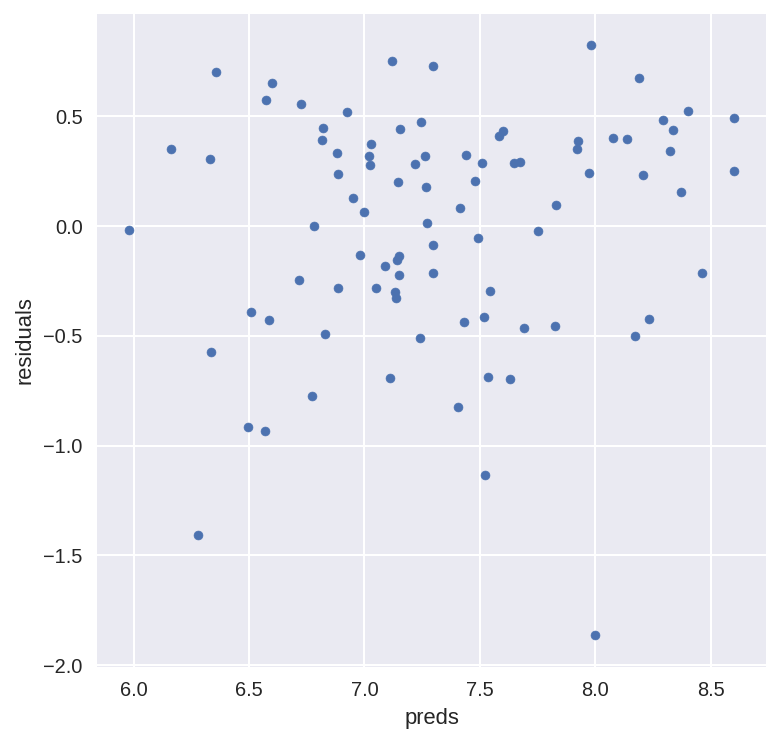

In [36]:
plot_residual(lasso_adjusted, H, y)

The Lasso regression has a little difference in comparison with Ridge regression.

### K-NN

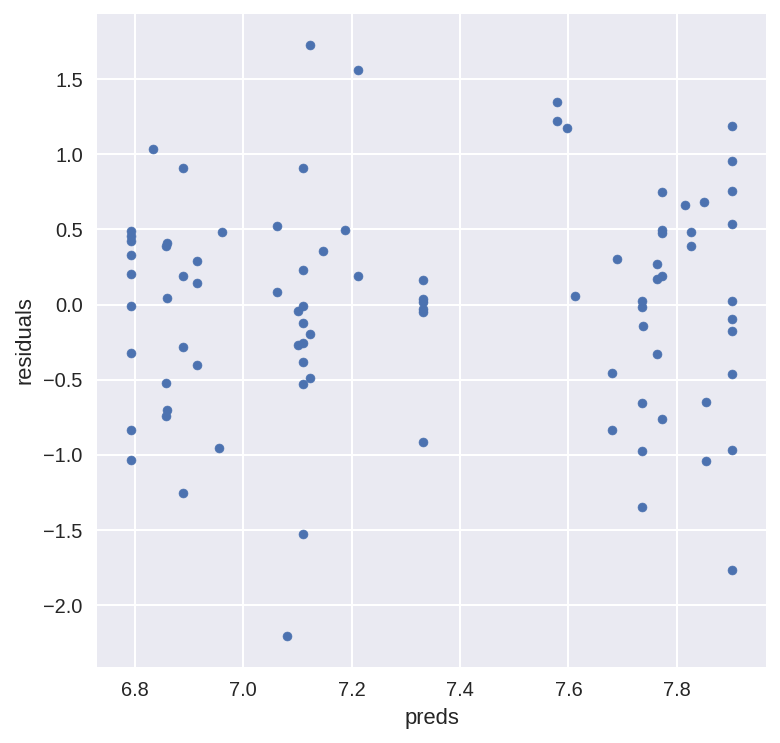

In [37]:
plot_residual(neigh, H, y)

This graphic shows some patterns in data (some columns in prediction).

### Test with real values

In [149]:
data_test = pd.read_csv("teste.csv")
y_p = data_test.drop(['matricula','Cálculo1','Vetorial','LPT','P1','IC','LP1','Cálculo2','Discreta','P2','Grafos','Fís.Clássica','LP2'], 1)
H_p = data_test.drop(['matricula','cra'], 1)
H_p = H_p[['Vetorial','LPT','P1','IC','LP1','Cálculo2','Discreta','P2','Grafos','Fís.Clássica','LP2','Cálculo1']]

y_knn = neighbor.predict(H_p)

H_p = np.c_[np.ones(len(H_p)), H_p]

w_ridge = np.r_[ridge_adjusted.intercept_, ridge_adjusted.coef_]
w_lasso = np.r_[lasso_adjusted.intercept_, lasso_adjusted.coef_]

y_ridge = np.dot(H_p, w_ridge)
y_lasso = np.dot(H_p, w_lasso)

#### Print RMSE for all classifiers

In [148]:
from sklearn.metrics import mean_squared_error

rmse_test_ridge = np.sqrt(mean_squared_error(y_ridge, y_p))
rmse_test_lasso = np.sqrt(mean_squared_error(y_lasso, y_p))
rmse_test_knn = np.sqrt(mean_squared_error(y_knn, y_p))

print("RMSE for Ridge Regression test: {0}".format(rmse_test_ridge))
print("RMSE for Lasso Regression test: {0}".format(rmse_test_lasso))
print("RMSE for K-NN test: {0}".format(rmse_test_knn))

RMSE for Ridge Regression test: 0.398812891013
RMSE for Lasso Regression test: 0.415672685389
RMSE for K-NN test: 0.769617556545


It was observed that RMSE in test group was smaller than in training phase (for Ridge and Lasso Regression), and bigger to K-NN.